In [1]:
import os
import json

import pandas as pd
import einops

import torch
import torch.nn.functional as F
from fancy_einsum import einsum
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from transformer_lens import (
    HookedTransformer,
)
from toxicity.figures.fig_utils import convert, load_hooked, get_svd
from constants import MODEL_DIR, DATA_DIR

torch.set_grad_enabled(False)

In [2]:

model = load_hooked(
    "gpt2-medium",
    os.path.join(MODEL_DIR, "dpo.pt"),
)
gpt2 = HookedTransformer.from_pretrained("gpt2-medium")
gpt2.tokenizer.padding_side = "left"
gpt2.tokenizer.pad_token_id = gpt2.tokenizer.eos_token_id

toxic_vector = torch.load(os.path.join(MODEL_DIR, "probe.pt"))

Loaded pretrained model gpt2-medium into HookedTransformer
Loaded pretrained model gpt2-medium into HookedTransformer


In [3]:

with open(
    os.path.join(DATA_DIR, "intervene_data/challenge_prompts.jsonl"), "r"
) as file_p:
    data = file_p.readlines()

prompts = [json.loads(x.strip())["prompt"] for x in data]
tokenized_prompts = model.to_tokens(prompts, prepend_bos=True).cuda()

In [4]:


_, scores_gpt2 = get_svd(gpt2, toxic_vector, 128)
vectors_of_interest = [
    (_score_obj[2], _score_obj[1], _score_obj[0])
    for _score_obj in scores_gpt2[:64]
]

In [5]:

gpt2_resid = []
dpo_resid = []
sample_size = 50
batch_size = 4
print("Grabbing mlp mids...")
_vec = vectors_of_interest[0]
_layer = _vec[0]
_idx = _vec[1]

for idx in tqdm(range(0, sample_size, batch_size)):
    batch = tokenized_prompts[idx : idx + batch_size, :]
    dpo_batch = batch.clone()

    with torch.inference_mode():
        _, cache = gpt2.run_with_cache(batch)
        resid = cache[f"blocks.{_layer}.hook_resid_mid"][:, -1, :]

    gpt2_resid.extend(resid.cpu().tolist())

    with torch.inference_mode():
        _, cache = model.run_with_cache(dpo_batch)
        resid = cache[f"blocks.{_layer}.hook_resid_mid"][:, -1, :]
    dpo_resid.extend(resid.cpu().tolist())


w_ins = [
    gpt2.blocks[_layer].mlp.W_in[:, _idx].cpu(),
    model.blocks[_layer].mlp.W_in[:, _idx].cpu(),
]

gpt2_stacked = torch.stack([torch.Tensor(x) for x in gpt2_resid], dim=0)
dpo_stacked = torch.stack([torch.Tensor(x) for x in dpo_resid], dim=0)
gpt2_dots = einsum("sample d_model, d_model", gpt2_stacked, w_ins[0])
dpo_dots = einsum("sample d_model, d_model", dpo_stacked, w_ins[1])
gpt_acts = model.blocks[0].mlp.act_fn(gpt2_dots)
dpo_acts = model.blocks[0].mlp.act_fn(dpo_dots)

Grabbing mlp mids...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.18it/s]


torch.Size([1024])
11.933368682861328
-0.0
13.847200393676758
-0.0
26.401968002319336
24.49401092529297
5.835847854614258
0.4391503632068634
26.874244689941406
10.650365829467773
9.047333717346191
1.1667826175689697
12.976777076721191
19.238019943237305
-0.0
-0.0
26.568723678588867
24.608760833740234
8.549989700317383
2.96732759475708
12.697152137756348
9.083166122436523
-0.004181285854429007
6.6472063064575195
-0.0784885436296463
18.135242462158203
5.277504920959473
0.8333429098129272
14.884654998779297
0.6342859268188477
____
1.7476341724395752
-0.0
4.84157657623291
-0.0
14.063610076904297
12.575393676757812
-0.1570473462343216
-0.0
12.956071853637695
0.9889507293701172
-0.1555277705192566
-0.0
2.1770577430725098
5.681166172027588
-0.0
-0.0
11.87281322479248
10.284687042236328
-0.0002197946305386722
-3.951676262659021e-05
3.119166135787964
1.0556527376174927
-0.0
-0.16180898249149323
-0.0
7.465394020080566
-0.01901228539645672
-4.5808523282175884e-05
2.4970977306365967
-0.0


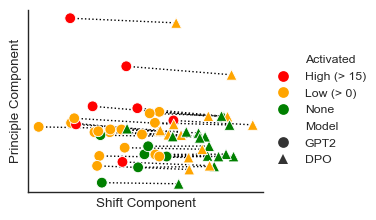

In [6]:

all_data = torch.concat([gpt2_stacked, dpo_stacked], dim=0)
mean = all_data.mean(dim=0)
stddev = all_data.std(dim=0)
normalized = (all_data - mean) / stddev

U, S, V = torch.pca_lowrank(normalized)

diff = dpo_stacked - gpt2_stacked
diff_mean = diff.mean(dim=0)
print(diff_mean.shape)

comps = torch.concat([diff_mean.unsqueeze(-1), V], dim=1)
comps = comps[:, :2]
projected = torch.mm(normalized, comps)

pca_raw = []
num_samples = 30
for idx in range(num_samples):

    _activation = gpt_acts[idx].item()
    if _activation > 15:
        act = "High (> 15)"
    elif _activation > 0:
        act = "Low (> 0)"
    else:
        act = "None"

    print(_activation)
    pca_raw.append(
        {
            "Model": "GPT2",
            "x": projected[idx, 0].item(),
            "y": projected[idx, 1].item(),
            "Activated": act,
        }
    )

_offset = len(gpt2_resid)
print("____")
for idx in range(num_samples):
    _activation = dpo_acts[idx].item()
    if _activation > 15:
        act = "High (> 15)"
    elif _activation > 0:
        act = "Low (> 0)"
    else:
        act = "None"
    print(_activation)
    pca_raw.append(
        {
            "Model": "DPO",
            "x": projected[_offset + idx, 0].item(),
            "y": projected[_offset + idx, 1].item(),
            "Activated": act,
        }
    )

pca_data = pd.DataFrame(pca_raw)
sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 1})

fig = sns.relplot(
    pca_data,
    x="x",
    y="y",
    hue="Activated",
    palette={"High (> 15)": "red", "Low (> 0)": "orange", "None": "green"},
    hue_order=["High (> 15)", "Low (> 0)", "None"],
    style="Model",
    markers={"GPT2": "o", "DPO": "^"},
    height=2.5,
    aspect=3.25 / 2.5,
    s=60,
    legend="full",
)

fig.ax.set_xticks([])
fig.ax.set_yticks([])
fig.ax.xaxis.label.set_text("Shift Component")
fig.ax.yaxis.label.set_text("Principle Component")
fig.ax.xaxis.label.set_visible(True)
fig.ax.yaxis.label.set_visible(True)

_offset = len(gpt2_resid)
for idx in range(num_samples):
    gpt2_x = projected[idx, 0].item()
    gpt2_y = projected[idx, 1].item()
    dpo_x = projected[_offset + idx, 0].item()
    dpo_y = projected[_offset + idx, 1].item()
    fig.ax.plot(
        [gpt2_x, dpo_x], [gpt2_y, dpo_y], color="black", ls=":", zorder=0
    )

plt.savefig(f"pca_layer{_layer}.pdf", bbox_inches="tight", dpi=1200)

Grabbing mlp mids...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.98it/s]


12.736486434936523
-0.1509389728307724
6.283715724945068
-1.500771276141677e-07
16.54439353942871
5.424770355224609
-0.1544327735900879
-0.0006558157037943602
4.492743968963623
3.3528242111206055
4.940762996673584
-0.08017945289611816
-0.0032243384048342705
14.11532211303711
4.84587287902832
5.431631565093994
1.7383004426956177
16.90298080444336
5.794865131378174
3.839339256286621
-0.1478295773267746
9.272611618041992
2.331369638442993
-5.615283498627832e-06
-0.013839775696396828
3.368499279022217
-0.14904452860355377
-0.11065510660409927
-0.0
-0.0
____
10.42776870727539
-0.011103641241788864
4.996962547302246
-0.0
15.074871063232422
4.061856746673584
-0.015638884156942368
-0.0
2.6754751205444336
1.4229226112365723
3.420182943344116
-0.0007810636889189482
-0.0
12.293710708618164
3.160348415374756
4.34404182434082
0.2307652086019516
13.408353805541992
3.0565829277038574
2.2402660846710205
-0.06397033482789993
7.311905384063721
-0.14980529248714447
-0.0
-0.0008870510500855744
1.754305481

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  9.67it/s]


11.914581298828125
1.8053650856018066
3.8912675380706787
-4.582037490763469e-06
25.908979415893555
20.5458984375
-0.0
-0.0
5.337183952331543
1.4169914722442627
7.016813278198242
7.943212985992432
11.849430084228516
11.696284294128418
4.314500331878662
3.3890185356140137
-0.003583882935345173
18.012481689453125
4.824355602264404
8.934440612792969
7.532619476318359
5.260843753814697
-0.0
3.9534060955047607
-0.016461817547678947
-0.0009466778137721121
-0.16987796127796173
-0.0
5.247683525085449
10.284181594848633
____
5.576327323913574
-0.04551732912659645
-0.10309260338544846
-0.0
20.26849365234375
14.805378913879395
-0.0
-0.0
-0.016108686104416847
-9.939226401911583e-07
5.070073127746582
1.7482229471206665
7.005546569824219
4.505810737609863
0.5705756545066833
1.9044736623764038
-0.0
9.207841873168945
-0.0011359078343957663
4.89633321762085
1.7532296180725098
0.5542991757392883
-0.0
-0.15855878591537476
-0.0
-0.0
-0.0
-0.0
0.047237005084753036
7.308445453643799
Grabbing mlp mids...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:01<00:00,  8.97it/s]


-0.07945673167705536
-0.0
3.395420789718628
7.461334228515625
17.84363555908203
7.973690986633301
-0.00968853197991848
-2.9744262519670883e-07
12.100505828857422
-0.08950512856245041
4.08964204788208
4.996271133422852
6.343166828155518
12.051959991455078
-0.0
2.5086755752563477
-0.12145418673753738
7.741948127746582
0.488880455493927
5.967020034790039
1.7519620656967163
5.557199478149414
3.725426435470581
3.5864901542663574
6.845648288726807
10.368698120117188
2.127636194229126
0.8206822276115417
2.4109790325164795
0.027278488501906395
____
-1.2294914995436557e-05
-0.0
0.43664994835853577
4.469868183135986
14.639054298400879
5.411495685577393
-2.9486716357496334e-07
-0.0
8.723503112792969
-0.009623650461435318
0.8456264138221741
1.3908618688583374
3.333045721054077
8.837793350219727
-0.0
-0.06253961473703384
-0.0018610022962093353
2.7366955280303955
-0.0016367322532460093
3.1166703701019287
-0.09385018795728683
2.5017998218536377
0.43064084649086
0.7740375995635986
4.278610706329346
7.

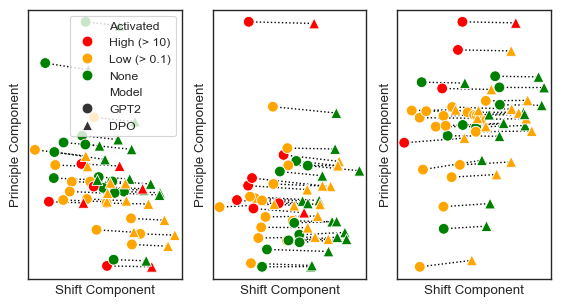

In [7]:


fig = plt.figure(figsize=(6.75, 3.5))
gs = GridSpec(1, 3)
boundaries = [
    (0.1, 10),
    (0.1, 10),
    (0.1, 10),
]

for vec_idx in [1, 2, 3]:

    gpt2_resid = []
    dpo_resid = []
    sample_size = 50
    batch_size = 4
    print("Grabbing mlp mids...")
    _vec = vectors_of_interest[vec_idx]
    _layer = _vec[0]
    _idx = _vec[1]

    for idx in tqdm(range(0, sample_size, batch_size)):
        batch = tokenized_prompts[idx : idx + batch_size, :]
        dpo_batch = batch.clone()

        with torch.inference_mode():
            _, cache = gpt2.run_with_cache(batch)
            resid = cache[f"blocks.{_layer}.hook_resid_mid"][:, -1, :]

        gpt2_resid.extend(resid.cpu().tolist())

        with torch.inference_mode():
            _, cache = model.run_with_cache(dpo_batch)
            resid = cache[f"blocks.{_layer}.hook_resid_mid"][:, -1, :]
        dpo_resid.extend(resid.cpu().tolist())

    w_ins = [
        gpt2.blocks[_layer].mlp.W_in[:, _idx].cpu(),
        model.blocks[_layer].mlp.W_in[:, _idx].cpu(),
    ]

    gpt2_stacked = torch.stack([torch.Tensor(x) for x in gpt2_resid], dim=0)
    dpo_stacked = torch.stack([torch.Tensor(x) for x in dpo_resid], dim=0)
    gpt2_dots = einsum("sample d_model, d_model", gpt2_stacked, w_ins[0])
    dpo_dots = einsum("sample d_model, d_model", dpo_stacked, w_ins[1])
    gpt_acts = model.blocks[0].mlp.act_fn(gpt2_dots)
    dpo_acts = model.blocks[0].mlp.act_fn(dpo_dots)

    all_data = torch.concat([gpt2_stacked, dpo_stacked], dim=0)
    mean = all_data.mean(dim=0)
    stddev = all_data.std(dim=0)
    normalized = (all_data - mean) / stddev

    U, S, V = torch.pca_lowrank(normalized)

    diff = dpo_stacked - gpt2_stacked
    diff_mean = diff.mean(dim=0)

    comps = torch.concat([diff_mean.unsqueeze(-1), V], dim=1)
    comps = comps[:, :2]
    projected = torch.mm(normalized, comps)

    pca_raw = []
    num_samples = 30

    _boundary = boundaries[vec_idx - 1]
    for idx in range(num_samples):

        _activation = gpt_acts[idx].item()
        if _activation > _boundary[1]:
            act = f"High (> {_boundary[1]})"
        elif _activation > _boundary[0]:
            act = f"Low (> {_boundary[0]})"
        else:
            act = "None"

        print(_activation)
        pca_raw.append(
            {
                "Model": "GPT2",
                "x": projected[idx, 0].item(),
                "y": projected[idx, 1].item(),
                "Activated": act,
            }
        )

    _offset = len(gpt2_resid)
    print("____")
    for idx in range(num_samples):
        _activation = dpo_acts[idx].item()
        if _activation > _boundary[1]:
            act = f"High (> {_boundary[1]})"
        elif _activation > _boundary[0]:
            act = f"Low (> {_boundary[0]})"
        else:
            act = "None"
        print(_activation)
        pca_raw.append(
            {
                "Model": "DPO",
                "x": projected[_offset + idx, 0].item(),
                "y": projected[_offset + idx, 1].item(),
                "Activated": act,
            }
        )

    pca_data = pd.DataFrame(pca_raw)
    sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 1})

    ax = fig.add_subplot(gs[0, vec_idx - 1])

    legend = None
    if vec_idx == 1:
        legend = "full"

    sns.scatterplot(
        pca_data,
        x="x",
        y="y",
        hue="Activated",
        palette={
            f"High (> {_boundary[1]})": "red",
            f"Low (> {_boundary[0]})": "orange",
            "None": "green",
        },
        hue_order=[
            f"High (> {_boundary[1]})",
            f"Low (> {_boundary[0]})",
            "None",
        ],
        style="Model",
        markers={"GPT2": "o", "DPO": "^"},
        s=60,
        legend=legend,
        ax=ax,
    )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.xaxis.label.set_text("Shift Component")
    ax.yaxis.label.set_text("Principle Component")
    ax.xaxis.label.set_visible(True)
    ax.yaxis.label.set_visible(True)

    _offset = len(gpt2_resid)
    for idx in range(num_samples):
        gpt2_x = projected[idx, 0].item()
        gpt2_y = projected[idx, 1].item()
        dpo_x = projected[_offset + idx, 0].item()
        dpo_y = projected[_offset + idx, 1].item()
        ax.plot(
            [gpt2_x, dpo_x], [gpt2_y, dpo_y], color="black", ls=":", zorder=0
        )

plt.savefig(f"pca_layer_appx.pdf", bbox_inches="tight", dpi=1200)